# Script for analysis in WW paper

## Notes:
The data processing has been implemented in a seperate file, and outputted to a CSV. There is a reasonable amount of cleaning (mapping relationships between raw data files) that has gone on elesewhere and is not included here.

The analysis here is carried out at "Covid Infection Survey" level, which is the sub-regional levels as specified by ONS. These data are amn aggregation of data from specific WW sites within each sub-region. This is described in more detail in the paper.

## 0. import relevant libraries

Note that this includes the "wastewater.ml_utils" library that was developed within UKHSA to support working with the WW data

In [1]:
# libraries
# note these may require installation, easiest to use "pip install XX" in the cmd
import numpy as np
import pandas as pd
import sklearn 
import scipy
#import geopandas as gpd
import seaborn as sns  # for boxplots
import xgboost as xgb
import datetime
import matplotlib.pylab as plt
#import wastewater as ww
from ml_utils import Dataset, RandomIntercepts, RandomEffects

### 1. read in data

In [2]:
# dataframe to use 'agg_data_inner_11_cis_mar22.csv'
df = pd.read_csv('agg_data_inner_11_cis_mar22.csv',
                 parse_dates=['date'],
                 dayfirst=True,
                )
print(df.shape)
list(df.columns)


(7238, 22)


['Unnamed: 0',
 'CIS20CD',
 'date',
 'sars_cov2_gc_l_mean',
 'suspended_solids_mg_l',
 'ammonia_mg_l',
 'ophosph_mg_l',
 'sample_ph_pre_ansis',
 'control_gc_l_mean',
 'reac_vol_control',
 'raw_ansis_sars_repc_std',
 'grab_compo_boo',
 'sars_below_lod',
 'sars_below_loq',
 'reception_delay',
 'catchment_population_ons_mid_2019',
 'catchment_area',
 'catch_in_cis_prop',
 'catch_cis_population',
 'median_prob',
 'll',
 'ul']

[*Notes*]
Key variables in the data;
- **median_prob** - the positivity values from the CIS (ll and ul) are the 95% CI. In the analysis this is our outcome variable
- **sars_cov2_gc_l_mean** - the reported sars-cov-2 values (gc/l) (this is aggregated from each site)
- **raw_ansis_sars_repc_std** - the standard deviation of the replicate samples of sars_cov2_gc_l
- The remaining variales should be pretty self-explanatory, but do get in touch if this isn't the case.

In [3]:
# rename a few variables to improve plotting
df.rename(columns={'cis20cd': 'CIS20CD'}, inplace=True)
df.rename(columns={'grab_compo_boo': 'compo_frac'}, inplace=True)  # ,#,

variable_labels = {
    'sars_cov2_gc_l_mean': 'SARS-CoV-2 concentration',
    'sample_ph_pre_ansis':'sample pH',
    'ammonia_mg_l':'ammonia concentration',
    'ophosph_mg_l':'phosphate concentration',
    'suspended_solids_mg_l':'suspended solids',
    'sars_below_loq':'below LOQ',
    'sars_below_lod':'below LOD',
    'reception_delay':'reception delay',
    'catch_cis_population':'covered population',
    'catch_in_cis_prop':'subregion population fraction',
    "catchment_population_ons_mid_2019": "catchment population",
    "catchment_area": 'catchment area'
}

## 2. Summary tables

These summary tables are provided in the *Supplementary Information* of the paper.

In [4]:
cols = ['sars_cov2_gc_l_mean','raw_ansis_sars_repc_std',
        'sars_below_lod','sars_below_loq',
        'reac_vol_control',
       'sample_ph_pre_ansis','ammonia_mg_l',
       'ophosph_mg_l','suspended_solids_mg_l',
        'reception_delay'
       ]
t1 = df[cols].describe()
print(t1)
print(df.shape)
# write to file
t1.to_csv('data_describe_agg_mar22.csv') 


       sars_cov2_gc_l_mean  raw_ansis_sars_repc_std  sars_below_lod  \
count          7238.000000              7238.000000     7238.000000   
mean          34767.357741                39.945604        0.348232   
std           63126.912852                75.069530        0.464059   
min               1.793858                 0.000000        0.000000   
25%            3428.783223                 3.988529        0.000000   
50%           12036.753066                13.843835        0.000000   
75%           38913.436746                43.290314        1.000000   
max          790518.720052               869.771240        1.000000   

       sars_below_loq  reac_vol_control  sample_ph_pre_ansis  ammonia_mg_l  \
count     7238.000000            7238.0          7238.000000   7238.000000   
mean         0.030144               2.0             7.591386     29.108519   
std          0.162546               0.0             0.153371     13.829438   
min          0.000000               2.0         

## 3. Plotting initial data

## 4. Models

In [5]:
# these variables will bethose included in the xgb model, etc, 
# State the variables that will be placed in each grouping, for ease of use later.
sample_variables = ['sars_cov2_gc_l_mean', 
                    'suspended_solids_mg_l', 'ammonia_mg_l', 'ophosph_mg_l', 
                    'sample_ph_pre_ansis', 
                    'raw_ansis_sars_repc_std',
                    'compo_frac',
                    'sars_below_lod', 'sars_below_loq', 
                    'reception_delay',
                   ]

site_variables = ['catchment_population_ons_mid_2019',
                  'catchment_area',
]

cis_variables = ['catch_in_cis_prop', 'catch_cis_population',] # 

all_variables = sample_variables + site_variables + cis_variables

[*Notes*] 
- The models, linear model (lr), linear model with random intercepts (ri), linear model with random effects (re), gradient boosted with no covariates (xgb0), and gradient boosted with covariates (xgb) are all specified below.
- We then go straight into predictions, where we perform out of sample predictions that are repeated 50 times (we refer to them as bootstrap, but it isn't really a bootstrap).
- The outcome that is monitored is the mean absolute error (MSE). In the methods we describe this in much more detail.

In [6]:
from sklearn.linear_model import LinearRegression
from ml_utils import RandomIntercepts, RandomEffects  # we've done this already?
from xgboost import XGBRegressor

dict_models = dict(lr = LinearRegression(),
                   xgb = XGBRegressor(),
                   xgb0 = XGBRegressor(),
                   ri = RandomIntercepts('CIS20CD'),
                   re = RandomEffects('CIS20CD', 
#                                       slope_vars=['sars_cov2_gc_l_mean'], 
                                      correlated_re=False))

model_variables = dict(lr = all_variables,
                       xgb = all_variables,
                       xgb0 = ['sars_cov2_gc_l_mean'],
                       ri =  ['sars_cov2_gc_l_mean', #'control_gc_l_mean', #'reac_vol_control', 
                             'suspended_solids_mg_l', 'ammonia_mg_l', 
                              'ophosph_mg_l', 
                             'sample_ph_pre_ansis', 
                             # 'compo_frac',
                             'sars_below_lod', 
                              'sars_below_loq'
                             ],
                       re = ['sars_cov2_gc_l_mean', #'control_gc_l_mean', # 'reac_vol_control', 
                             'suspended_solids_mg_l', 'ammonia_mg_l', 
                             'ophosph_mg_l', 
                             'sample_ph_pre_ansis', 
                             'compo_frac',
                             'sars_below_lod', 
                             'sars_below_loq'
                            ]
                      )

# model_variables = dict(lr=['sars_cov2_gc_l_mean'],
#                        xgb=['sars_cov2_gc_l_mean'],
#                        ri=['sars_cov2_gc_l_mean'],
#                        re=['sars_cov2_gc_l_mean'])

model_labels = {'lr': 'Linear Regression', 'ri': 'Random Intercepts', 
                're': 'Random Effects','xgb': 'Gradient Boosted',
                'xgb0': 'Gradient Boosted (null)',
               'process': 'Process-based'}

# Predictions

In [7]:
# Metrics
compute_mae = lambda y, pred: np.abs(pred-y).mean()
compute_mae_natural = lambda y, pred: np.abs(10**pred-10**y).mean()

print(compute_mae)
print(compute_mae_natural)

<function <lambda> at 0x7f9e313b5dd0>
<function <lambda> at 0x7f9e313b5ef0>


In [9]:
# Bootstrap predictions
from ml_utils import bootstrap

repeat = 50
preds_bootstrap = {}

models = ['xgb','xgb0','lr', 'ri'] #,'re' remove some models as desired, as RE can be long for example

for model_name in models: 
    print(model_name)
    dataset = Dataset(df.set_index(['CIS20CD', 'date']), model_variables[model_name], 
                      'median_prob', input_offset=0.001)
    x, y = dataset.prepare_no_split()
    preds_bootstrap[model_name] = bootstrap(dict_models[model_name], x, y, repeat=repeat)

xgb


100%|███████████████████████████████████████████| 50/50 [00:40<00:00,  1.23it/s]


xgb0


100%|███████████████████████████████████████████| 50/50 [00:22<00:00,  2.22it/s]


lr


100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 13.09it/s]


ri


100%|███████████████████████████████████████████| 50/50 [00:30<00:00,  1.65it/s]


In [12]:
# Computing MEan and SE of errors

dict_pred = {model_name: preds_bootstrap[model_name].mean(1) for model_name in preds_bootstrap}
# dict_pred_natural = {model_name: 10**preds_bootstrap[model_name].mean(1) for model_name in preds_bootstrap}
dict_se = {model_name: pred.std(1)/np.sqrt(repeat - np.isnan(pred).sum(1)) for model_name, pred in preds_bootstrap.items()}
dict_se_natural = {model_name: 10**pred.std(1)/np.sqrt(repeat - np.isnan(pred).sum(1)) for model_name, pred in preds_bootstrap.items()}

# Export of scores 
save = True
if save:
    for model_name in dict_pred:
        dict_pred[model_name].to_csv(f'predictions_{model_name}.csv')

/Users/lsh1603970/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


mean absolute error 0.1348
median absolute error 0.0994
q95 absolute error 0.3913

Natural space
median relative error 22.7287
q95 relative error 105.5719
median absolute error 19.0073
q95 absolute error 99.1167


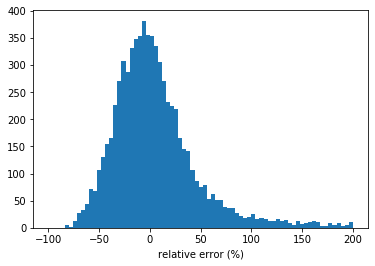

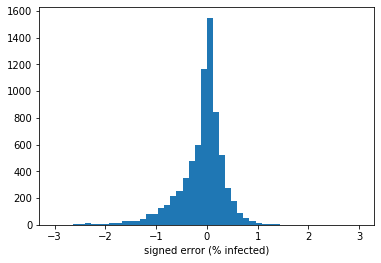

In [13]:
# Printing some metrics for one model
model_name = 'xgb'   # 'lr' 'ri'  're'

# Log space
# print('Log Space')
# print(f'median relative error {np.abs((dict_pred[model_name]-y)/y).median()*100:.4f} %')
# print(f'q95 relative error {np.quantile(np.abs((dict_pred[model_name]-y)/y), 0.95)*100:.4f}')
print(f'mean absolute error {np.abs((dict_pred[model_name]-y)).mean():.4f}')
print(f'median absolute error {np.abs((dict_pred[model_name]-y)).median():.4f}')
print(f'q95 absolute error {np.quantile(np.abs((dict_pred[model_name]-y)), 0.95):.4f}')

# Natural space
print('\nNatural space')
print(f'median relative error {np.abs((10**dict_pred[model_name]-10**y)/10**y).median()*100:.4f}')
print(f'q95 relative error {np.quantile(np.abs((10**dict_pred[model_name]-10**y)/10**y), 0.95)*100:.4f}')

print(f'median absolute error {np.abs((10**dict_pred[model_name]-10**y)).median()*100:.4f}')
print(f'q95 absolute error {np.quantile(np.abs((10**dict_pred[model_name]-10**y)), 0.95)*100:.4f}')

plt.hist((10**dict_pred[model_name]-10**y)/10**y*100, 75, range=(-100, 200))
plt.xlabel('relative error (%)')
plt.show()

plt.hist((10**dict_pred[model_name]-10**y), 50, range=(-3,3))
plt.xlabel('signed error (% infected)')
pass

Estimated MAE (XGB) =  0.13453446502628819


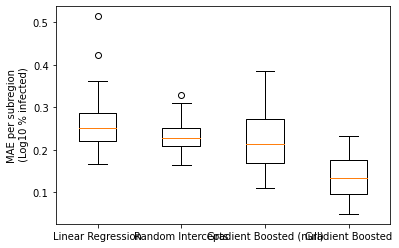

In [58]:
# Boxplot comparison for different models

names = ['lr','ri','xgb0','xgb'] #'process', 
per_subregion = True

dict_err = {name: np.abs((dict_pred[name] -y)) if not per_subregion else np.abs((dict_pred[name] -y)).groupby('CIS20CD').mean() for name in names}

#print(dict_err['xgb'])
print('Estimated MAE (XGB) = ',dict_err['xgb'].mean())

plt.boxplot([dict_err[name] for name in names], 
           )
plt.xticks(range(1, 1+len(names)), labels=[model_labels[name] for name in names])
plt.ylabel(f"MAE {'per subregion' if per_subregion else ''}\n (Log10 % infected)")
#plt.show()
plt.savefig(f'{ww.data_dir}/fS8_mae_by_model.png')           

pass
           
# #add plot by region here?
           
# dict_err = {name: np.abs((10**dict_pred[name] - 10**y)) if not per_subregion else np.abs((10**dict_pred[name] - 10**y)).groupby('CIS20CD').mean() for name in names}
# plt.boxplot([dict_err[name] for name in names], 
#            )
# plt.xticks(range(1, 1+len(names)), labels=[model_labels[name] for name in names])
# plt.ylabel(f"MAE {'per subregion' if per_subregion else ''}\n (% infected)", fontsize=14)
# plt.yscale('log')
# plt.yticks(fontsize=12)
# pass

KeyError: 're'

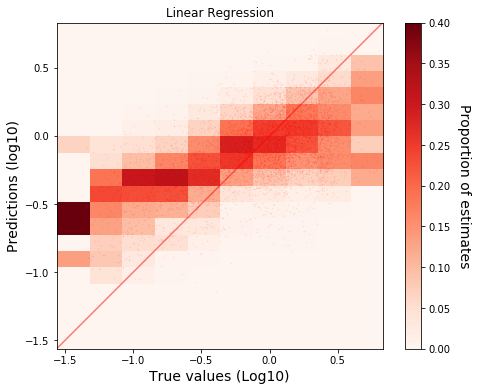

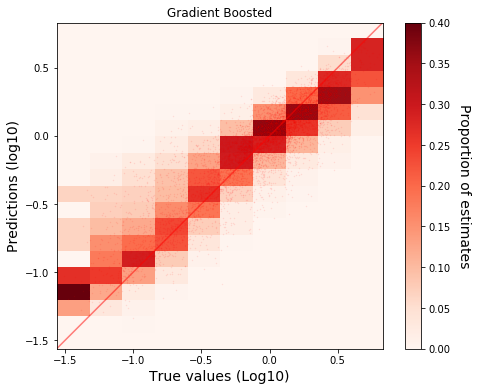

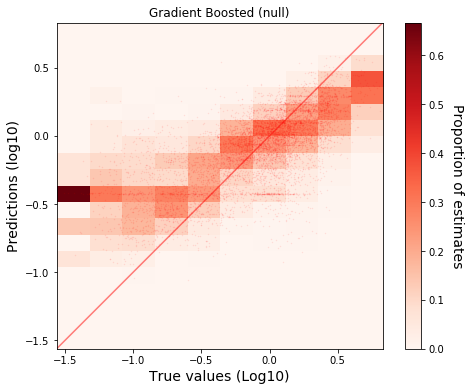

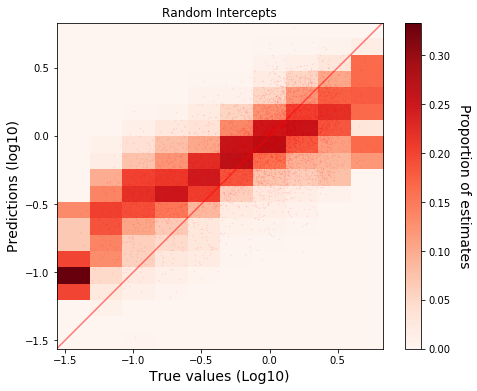

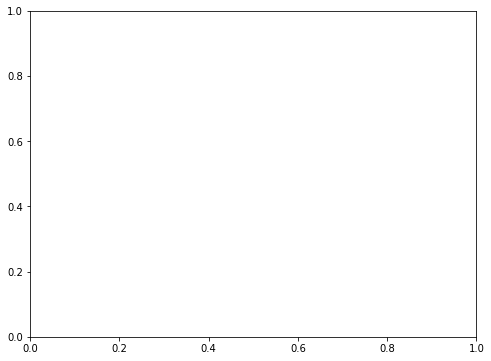

In [15]:
from ml_utils import plot_conditional_pred

for name in dict_models:
    fig, ax = plt.subplots(figsize=(8,6))
    plot_conditional_pred(dataset.y, dict_pred[name], title=model_labels[name], ax=ax)
    ax.set_ylabel(f'Predictions (log10)', fontsize=14)
    ax.set_xlabel('True values (Log10)', fontsize=14)
    #plt.savefig('f4_prediction_{}.png'.format(name)) # save to main file loc (commented out)


### Plot national average of predictions (Fig 1)

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


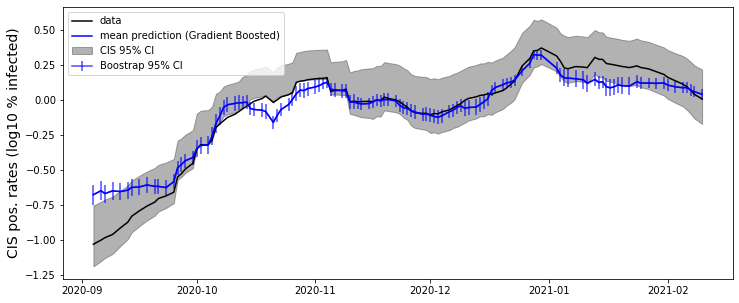

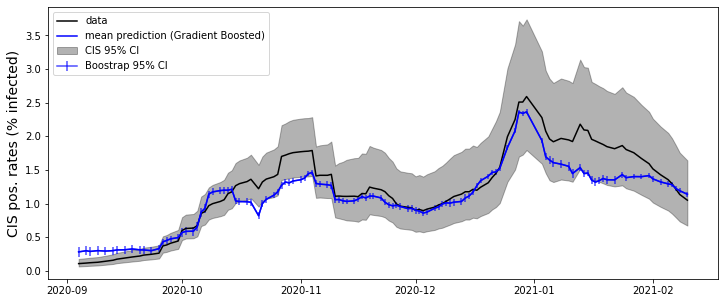

In [16]:
plt.figure(figsize=(12, 5))
model_name = 'xgb'
z = dict_pred[model_name].groupby('date').mean()
z_se = dict_se[model_name].groupby('date').mean()

z_cis = df[['CIS20CD', 'date', 'median_prob', "ll", 'ul']].groupby('date').mean().rolling('7D').mean()


plt.plot(y.groupby('date').mean().rolling('7D').mean(), color='black', label='data')
plt.fill_between(z_cis.index, 
                 np.log10(z_cis.ll), 
                 np.log10(z_cis.ul), alpha=0.3, color='black', label='CIS 95% CI')
plt.plot(z.rolling('7D').mean(),
         color='blue', label=f'mean prediction ({model_labels[model_name]})')
plt.errorbar(z.index, 
             z.rolling('7D').mean(), 
             2*z_se.rolling('7D').mean(),
             color='blue', alpha=0.7, label='Boostrap 95% CI')
plt.ylabel('CIS pos. rates (log10 % infected)', fontsize=14)
plt.legend()

# Natural space
plt.figure(figsize=(12, 5))
model_name = 'xgb'
z = (10**dict_pred[model_name]).groupby('date').mean()
z_se_natural = dict_se_natural[model_name].groupby('date').mean()

plt.plot((10**y).groupby('date').mean().rolling('7D').mean(), color='black', label='data')
plt.fill_between(z_cis.index, 
                 z_cis.ll, 
                 z_cis.ul, alpha=0.3, color='black', label='CIS 95% CI')
plt.plot(z.rolling('7D').mean(),
         color='blue', label=f'mean prediction ({model_labels[model_name]})')
plt.errorbar(z.index, 
             z.rolling('7D').mean(), 
             2*z_se.rolling('7D').mean(),
             color='blue', alpha=0.7, label='Boostrap 95% CI')
plt.ylabel('CIS pos. rates (% infected)', fontsize=14)
plt.legend(loc='upper left')


##### Subregional average of predictions

In [17]:
# this one is difficult to plot becuase we are loading lots of stuff in again
# to avoid this, the original data needs to have the regions included,
# load in df_cis
# CIS Data
df_cis = ww.load_cis(daily=False).rename(columns={'CIS.name':"CIS20CD"})
df_cis_interpolated = ww.load_cis(daily=True, kind='linear').rename(columns={'CIS.name':"CIS20CD"})


model_name = "xgb"

include_ww = True

region_names = ww.read_dataset('LOOKUP_REGISTER_ONS_GEO_CODE').set_index('region_code')[['region_name']].dropna().drop_duplicates()
region_names = region_names.reset_index().rename(columns={'region_code': 'RGN19CD'})

regions = df_cis[['CIS20CD', 'RGN19CD']].drop_duplicates().merge(region_names)
z = dataset.inverse_transform_y(dict_pred[model_name]).reset_index().merge(regions)
z = z.rename(columns={0: 'pred'}).merge(df[['sars_cov2_gc_l_mean', 'catch_cis_population', 'CIS20CD', 'date', 'median_prob', "ll", 'ul']])


se_natural = (dataset.inverse_transform_y(preds_bootstrap[model_name]).std(1) 
              / np.sqrt(repeat - np.isnan(preds_bootstrap[model_name]).sum(1)))
z = z.merge(se_natural.reset_index().rename(columns={0: 'se'}))


regions = ['North West','Yorkshire and The Humber',  'North East', 
           'West Midlands', 'East Midlands', 'East of England', 
           'South West', 'London', 'South East']

fig, axes = plt.subplots(3,3, figsize=(14,9), sharex=True, sharey=True)

for i, (region, ax) in enumerate(zip(regions, axes.flatten())):
    group = z[z.region_name == region]
    def fn(x):
        x = x[~np.isnan(x)]
        if not len(x):
            return np.nan
        weights = group.loc[x.index, 'catch_cis_population']
        if np.sum(weights) == 0.:
            weights = np.ones(x.shape)
        return np.average(x, weights=weights)
#     fn = lambda x: x.mean()

    group = group.groupby('date').agg(fn)

    ax.plot(group.median_prob.rolling('7D').mean(), color='black', alpha=0.8, label='CIS median proba')
    ax.fill_between(group.rolling('7D').mean().index, 
                    group.rolling('7D').mean().ll, 
                    group.rolling('7D').mean().ul, alpha=0.3, color='black', label='CIS 95% CI')
    
    ax.plot(group.pred.rolling('7D').mean(), color='blue', lw=2, alpha=0.8, label=f'predictions')
#     ax.plot(group.d.rolling('7D').mean(), color='blue', lw=2, alpha=0.8, label=f'predictions ({model_labels[model_name]})')
    ax.errorbar(group.pred.rolling('7D').mean().index, 
                group.pred.rolling('7D').mean(),
                2*group.se.rolling('7D').mean(),
                color='blue', fmt='none', alpha=0.5, label=f'boostrap 95% CI')
    
    if i%3==0:
        ax.set_ylabel('Prevalence (%)', fontsize=13)
    ax.set_title(region, fontsize=15)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    if  region == "South West":
#         ax.legend(loc='upper left', fontsize=11)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(np.array(handles)[[0, 2, 1, 3]], np.array(labels)[[0, 2, 1, 3]], loc='upper left', fontsize=12)
        
    if include_ww:
        ax2 = ax.twinx()
        ax2.plot(group.sars_cov2_gc_l_mean.rolling('7D').mean(), color='orange', lw=1.1, alpha=0.8, label=f'Wastewater data')
        
        if i%3==2:
            ax2.set_ylabel('SARS-CoV-2 (gc/L)', fontsize=13)
        else:
            ax2.set_yticks([])
        if  region == "South East":
            ax2.legend(loc='upper right', fontsize=12)
    ax2.set_ylim(-10000, 400000)
plt.tight_layout()
# save to file
# plt.savefig(f'{ww.data_dir}/f1_prediction_data_region.png') # save to main file loc


NameError: name 'ww' is not defined

          CIS20CD    RGN19CD region_name
count         116        116         116
unique        116          9           9
top     J06000101  E12000007      London
freq            1         27          27
      CIS20CD   mae_xgb    RGN19CD region_name  mae_xgb0
0   J06000104  0.172866  E12000001  North East  0.299945
1   J06000105  0.187566  E12000001  North East  0.279083
2   J06000107  0.178312  E12000002  North West  0.195992
3   J06000108  0.122762  E12000002  North West  0.140403
4   J06000109  0.145746  E12000002  North West  0.177153
..        ...       ...        ...         ...       ...
78  J06000209  0.093569  E12000009  South West  0.173108
79  J06000210  0.183562  E12000009  South West  0.279978
80  J06000213  0.185452  E12000009  South West  0.261992
81  J06000215  0.196120  E12000009  South West  0.319858
82  J06000216  0.233287  E12000009  South West  0.307760

[83 rows x 5 columns]


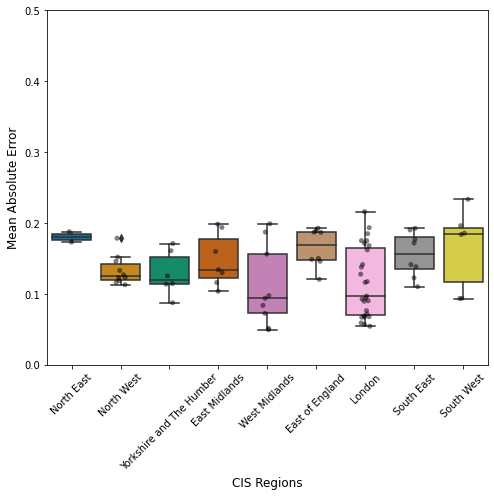

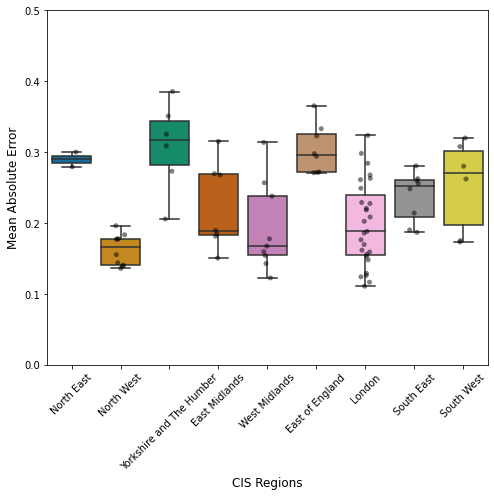

In [95]:
# boxplot of MAE by region (cis being the observations, so grouped by date)
model_name = 'xgb'

region_names = ww.read_dataset('LOOKUP_REGISTER_ONS_GEO_CODE').set_index('region_code')[['region_name']].dropna().drop_duplicates()
region_names = region_names.reset_index().rename(columns={'region_code': 'RGN19CD'})

regions = df_cis[['CIS20CD', 'RGN19CD']].drop_duplicates().merge(region_names)
print(regions.describe())  # 166
#z = dataset.inverse_transform_y(dict_pred[model_name]).reset_index().merge(regions)
#z = z.rename(columns={0: 'pred'}).merge(df[['sars_cov2_gc_l_mean', 'catch_cis_population', 'CIS20CD', 'date', 'median_prob', "ll", 'ul']])
#z['pred_log'] = np.log(z['pred'])
#print(z.columns)
#print(z.describe())
#print(dict_pred[model_name].describe())

#print(dict_err['xgb'])
#print('MAE (XGB) = ',dict_err['xgb'].describe())
#print('MAE (XGB 0) = ',dict_err['xgb0'].describe())
#print(dict_err['xgb'].type)
#print(dict_err['xgb'].size)  # 83 so 1 obs per sub-region

out = pd.DataFrame(dict_err['xgb'],columns = ['mae_xgb'])  # create dataframe
out.reset_index(inplace=True)   # make rownames a column
out2 = out.merge(regions,left_on='CIS20CD',right_on='CIS20CD') # merge the region data onto out
tmp = pd.DataFrame(dict_err['xgb0'],columns = ['mae_xgb0'])
#print(tmp)
tmp.reset_index(inplace=True) 
out3 = out2.merge(tmp,left_on='CIS20CD',right_on='CIS20CD')
print(out3)

# create boxplot
#z_sr.boxplot(by='region_name',column=['MAE'])
f, ax = plt.subplots(figsize=(7,7))
bplot = sns.boxplot(y='mae_xgb',x='region_name',
                   data=out3,
                   width=0.8,
                   palette="colorblind")
bplot = sns.stripplot(y='mae_xgb',x='region_name',
                   data=out2,
                      jitter=True,marker='o',alpha=0.5,color='black')
bplot.set_xlabel('CIS Regions', fontsize=12)
bplot.set_ylabel('Mean Absolute Error', fontsize=12)
#bplot.set_title(f'{model_labels[xgb]}', fontsize=12)
bplot.set_ylim(0, 0.5)
bplot.set_xticklabels(bplot.get_xticklabels(),rotation=45)
plt.tight_layout()
# save to file
plt.savefig(f'{ww.data_dir}/f3_mae_region_fullmod.png') # save to main file loc

f, ax = plt.subplots(figsize=(7,7))
bplot2 = sns.boxplot(y='mae_xgb0',x='region_name',
                   data=out3,
                   width=0.8,
                   palette="colorblind")
bplot2 = sns.stripplot(y='mae_xgb0',x='region_name',
                   data=out3,
                      jitter=True,marker='o',alpha=0.5,color='black')
bplot2.set_xlabel('CIS Regions', fontsize=12)
bplot2.set_ylabel('Mean Absolute Error', fontsize=12)
#bplot.set_title(f'{model_labels[xgb]}', fontsize=12)
bplot2.set_ylim(0, 0.5)
bplot2.set_xticklabels(bplot.get_xticklabels(),rotation=45)
plt.tight_layout()
# save to file
plt.savefig(f'{ww.data_dir}/f3_mae_region_nullmod.png') # save to main file loc




In [ ]:
# Dependence of errors with viral load
plt.figure(figsize=(10,6))

for name in ['lr', 're', 'xgb']:
    mean_list = []
    se_list = []
#     plt.scatter(x['sars_cov2_gc_l_mean'], np.abs(dict_pred[name] - y), s=3)

    _, bins = np.histogram(x['sars_cov2_gc_l_mean'], bins=7)
    for i in range(len(bins)-1):
        z = (np.abs(dict_pred[name] - y))[(x['sars_cov2_gc_l_mean']>=bins[i]) & (x['sars_cov2_gc_l_mean']<=bins[i+1])]
        mean_list.append(z.mean())
        se_list.append(z.std()/np.sqrt(len(z)))
    plt.scatter([(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)], 
                mean_list)
    plt.errorbar([(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)], 
                 mean_list, 2*np.array(se_list), label=model_labels[name])
plt.xlabel('SARS-CoV2 Concentration (gc/L)', fontsize=14)
plt.ylabel('Mean Absolute Error (Log10)', fontsize=14)
plt.legend(fontsize=14)

In [47]:
#compute sites error
save = False
agg = np.median

# Collect errors per site
list_mae = []
list_mae_natural = []

save = True
for model_name in dict_pred:
    list_mae.append((y - dict_pred[model_name]).groupby('CIS20CD').agg(lambda x: agg(np.abs(x))))
    list_mae[-1].name = model_name
    list_mae_natural.append((10**y - 10**dict_pred[model_name]).groupby('CIS20CD').agg(lambda x:  agg(np.abs(x))))
    list_mae_natural[-1].name = model_name
mae_per_site = pd.concat(list_mae, 1)
mae_natural_per_site = pd.concat(list_mae_natural, 1)

if save:
    mae_per_site.to_csv(f'{ww.data_dir}/cis_mae_per_site.csv')
# mae_per_site.corr(), mae_per_site.mean(), len(mae_per_site)


# histograms of site errors
# for col in ['process', 're', 'xgb']:
#     plt.hist(mae_per_site[col], label=model_labels[col],
#               alpha=0.5, range=(0, mae_per_site.max().max()), bins=30)
# plt.xlabel('MAE [log10(%)]', fontsize=15)
# plt.legend()

# for col in ['process', 're', 'xgb']:
#     plt.hist(mae_natural_per_site[col], label=model_labels[col], 
#              alpha=0.5, range=(0, mae_natural_per_site.max().max()), bins=30)
# plt.xlabel('Mean Absolute Error (% infected)', fontsize=15)
# plt.legend() 

# for model_name in ['re', 'xgb']:
#     plt.hist((10**dict_pred[model_name]-10**y)/10**y,label=model_labels[model_name], 
#     alpha=0.5, range=(-3, 3), bins=50)
# plt.xlabel('Error [% infected]', fontsize=15)
# plt.legend() 

/tmp/ipykernel_4794/2599835137.py:15: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  mae_per_site = pd.concat(list_mae, 1)
/tmp/ipykernel_4794/2599835137.py:16: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  mae_natural_per_site = pd.concat(list_mae_natural, 1)


# Var importance and coefs

##### XGB variable importance

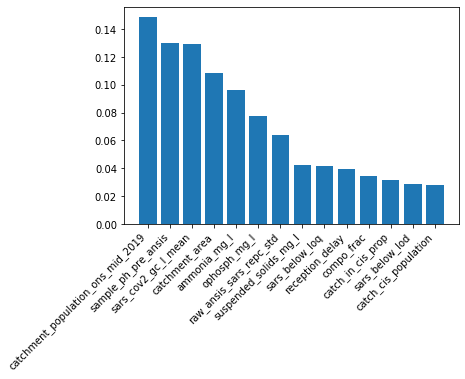

In [18]:
dataset = Dataset(df.set_index(['CIS20CD', 'date']), model_variables['xgb'], 'median_prob', 
                              input_offset=0.001)
x, y = dataset.prepare_no_split()
dict_models['xgb'].fit(x, y)
xgb_importance = pd.Series(dict_models['xgb'].feature_importances_, 
                           index=dataset.input_variables).sort_values(ascending=False)

plt.bar(xgb_importance.index, xgb_importance)
plt.xticks(rotation=45, horizontalalignment="right")
pass
#plt.savefig(f'{ww.data_dir}/f1_prediction_data_region.png') # save to main file loc


##### Partial dependence plots 

In [19]:
import numpy as np
# This function comes from here: https://github.com/dmlc/xgboost/issues/2035
def partial_dependency(model, X, features, selected_feature):
    # The model could be an XGBoost sklearn fitted instance (or anything else with a 
    # predict method)
    X_temp = X.copy()
    # Works only for numerical features. Find something else for categorical features.
    grid = np.linspace(np.percentile(X_temp.loc[:, selected_feature], 0.1), 
                       np.percentile(X_temp.loc[:, selected_feature], 99.5), 
                       50)
    y_pred = np.zeros(len(grid))
    
    for i, val in enumerate(grid):
        X_temp.loc[:, selected_feature] = val
        y_pred[i] = model.predict(X_temp.loc[:, features]).mean()
    
    return grid, y_pred

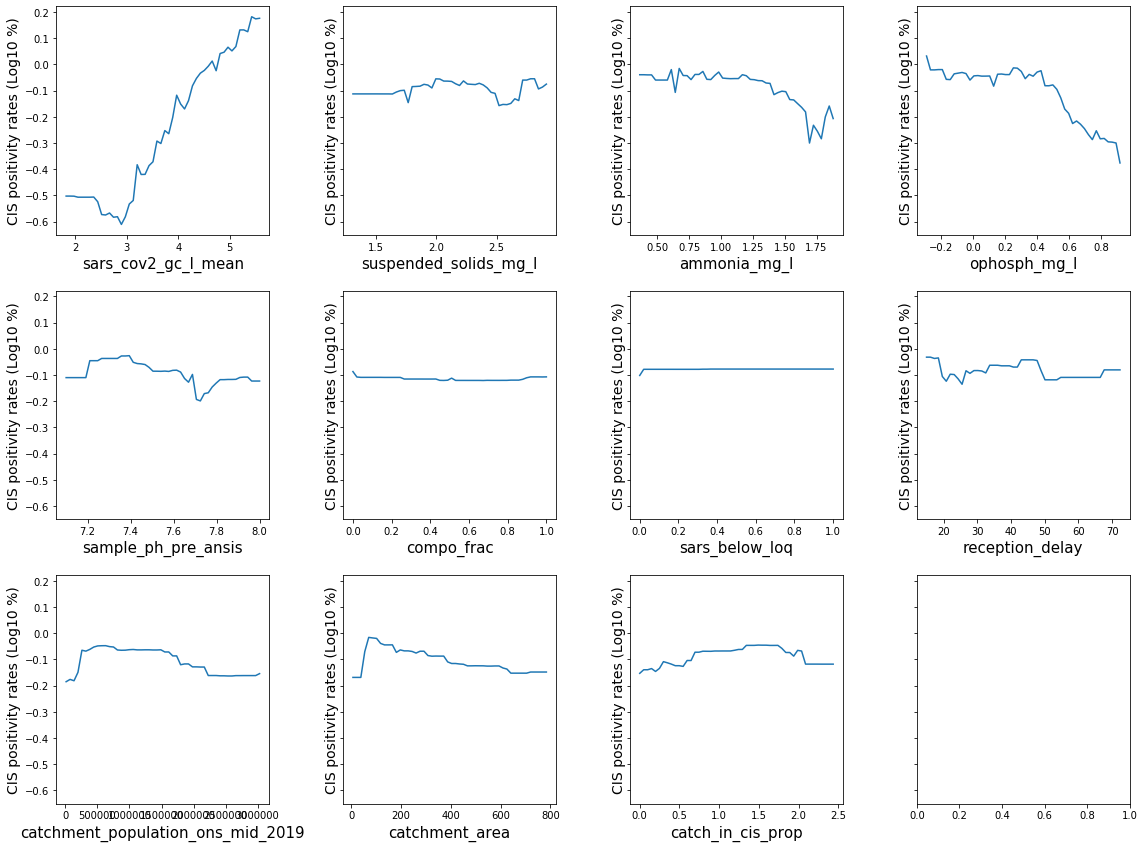

In [21]:
from sklearn.inspection import plot_partial_dependence
#variable_labels['Group'] = 'intercept'
model_name = "xgb"

dataset = Dataset(df.set_index(['CIS20CD', 'date']), model_variables[model_name], 
                      'median_prob', input_offset=0.001)
x, y = dataset.prepare_no_split()
model = dict_models[model_name]
model.fit(x, y)

# f, ax = plt.subplots(figsize=(15,15))
variables_to_plot = ['sars_cov2_gc_l_mean', 'suspended_solids_mg_l',
                     'ammonia_mg_l', 'ophosph_mg_l',
                     'sample_ph_pre_ansis',
                     'compo_frac',  'sars_below_loq',
                     'reception_delay', 'catchment_population_ons_mid_2019',
                     'catchment_area', 'catch_in_cis_prop'] #, 'catch_cis_population']

f, axes = plt.subplots(3, 4, figsize=(16,12), sharey=True)

for ax, selected_feature in zip(axes.flatten(), variables_to_plot):
    try:
        #print(selected_feature)
        grid, out = partial_dependency(model, x, x.columns, selected_feature)
        ax.plot(grid, out)
        #ax.set_xlabel(variable_labels[selected_feature], fontsize=15)
        ax.set_xlabel(selected_feature, fontsize=15)
        ax.set_ylabel('CIS positivity rates (Log10 %)', fontsize=14)
    except KeyError:
        continue
plt.tight_layout()
#plt.savefig(f'{ww.data_dir}/fS5_partial_dependency.png') # save to main file loc


# Shifts
This anlaysis explores the effects of shifting the WW data by a specified day (forwards/backwards) and comparing the MAE to the CIS and the TTI data.

In [79]:
from wastewater.ml_utils import predict_kfold, bootstrap

print(df_cis_interpolated.columns)

shifts = range(-10, 20, 1)
repeat= 50

mae_list = {name: [] for name in dict_models}
mae_sem_list ={name: [] for name in dict_models}
mae_natural_list = {name: [] for name in dict_models}
mae_natural_sem_list = {name: [] for name in dict_models}

models = ['lr', 'xgb']

df_ww_2 = df.copy()

print(df_ww_2['date'].describe)
print(df_cis_interpolated['date'].describe)

# Test of dates consistency
#assert df_cis_interpolated.date.min() >= df_ww_2.date.min() + datetime.timedelta(shifts[-1])
#assert df_cis_interpolated.date.max() <= df_ww_2.date.max() + datetime.timedelta(shifts[0])

for model_name in models:
    for shift in shifts:
        df_ww_shifted = df.copy()
        print('df copied')
        df_ww_shifted['date'] += datetime.timedelta(shift)
        df = df_ww_shifted.merge(df_cis_interpolated, how='inner').sort_values(['CIS20CD', 'date'])  # change for left
        df = df.dropna(subset=['CIS20CD', 'date'])
#         df = df[df.date > datetime.datetime(2020,8,1)]
        # Check on the compatibility of dates !


        print('Shift is ',shift, len(df))

        dataset = Dataset(df.set_index(['CIS20CD', 'date']), 
                          model_variables[model_name], 
                          'median_prob', 
                          input_offset=0.001
                         )
        x, y = dataset.prepare_no_split()

        model = sklearn.base.clone(dict_models[model_name])

        pred = predict_kfold(model, x, y)
        bootstrap_pred = bootstrap(dict_models[model_name], x, y, repeat=repeat)
        n_preds = repeat - np.isnan(bootstrap_pred).sum(1)


        mae_list[model_name].append(compute_mae(y, bootstrap_pred.mean(1)))
        mae_sem_list[model_name].append(np.abs(bootstrap_pred - y.values[:,np.newaxis]).mean(0).std() / np.sqrt(repeat))        
        
        mae_natural_list[model_name].append( np.abs(10**y - 10**bootstrap_pred.mean(1)).mean())
        mae_natural_sem_list[model_name].append(np.abs(10**bootstrap_pred - 10**y.values[:,np.newaxis]).mean(0).std() / np.sqrt(repeat))

Index(['date', 'median_prob', 'll', 'ul', 'CIS20CD'], dtype='object')
<bound method NDFrame.describe of 0      2020-09-04
1      2020-09-06
2      2020-09-07
3      2020-09-09
4      2020-09-11
          ...    
7233   2021-02-01
7234   2021-02-03
7235   2021-02-07
7236   2021-02-08
7237   2021-02-10
Name: date, Length: 7238, dtype: datetime64[ns]>
<bound method NDFrame.describe of 0       2020-09-03
1       2020-09-04
2       2020-09-05
3       2020-09-06
4       2020-09-07
           ...    
20731   2021-02-07
20732   2021-02-08
20733   2021-02-09
20734   2021-02-10
20735   2021-02-11
Name: date, Length: 20736, dtype: datetime64[ns]>
df copied
Shift is  -10 0


ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.

/tmp/ipykernel_4794/679932952.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  plt.plot(shifts, pd.Series(mae_list[model_name]).rolling(window, center=True, min_periods=1).mean(),


ValueError: x and y must have same first dimension, but have shapes (30,) and (0,)

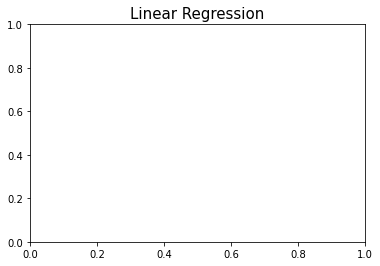

In [67]:
window = 1

for model_name in models:
    plt.figure()
    plt.title(model_labels[model_name], fontsize=15)
    plt.plot(shifts, pd.Series(mae_list[model_name]).rolling(window, center=True, min_periods=1).mean(), 
             '-o', markersize=6, color='blue', label="mean")
    plt.errorbar(shifts, pd.Series(mae_list[model_name]).rolling(window, center=True, min_periods=1).mean(), 
                 2 * np.array(mae_sem_list[model_name]), 
                 markersize=5,  color='blue', label='95% CI')
    plt.ylabel('Mean Absolute Error (log10 space)', fontsize=14)
    plt.xlabel('WW shift (days)', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    
for model_name in models:
    plt.figure()
    plt.title(model_labels[model_name], fontsize=15)
    plt.plot(shifts, pd.Series(mae_natural_list[model_name]).rolling(window, center=True, min_periods=1).mean(), 
             '-o', markersize=6, color='blue', label="mean")
    plt.errorbar(shifts, pd.Series(mae_natural_list[model_name]).rolling(window, center=True, min_periods=1).mean(), 
                 2 * np.array(mae_sem_list[model_name]), 
                 markersize=5,  color='blue', label='95% CI')
    plt.ylabel('Mean Absolute Error (natural)', fontsize=14)
    plt.xlabel('WW shift (days)', fontsize=14)
    plt.legend(fontsize=14)

In [ ]:
bucket = "s3://jbc-staging-data-wip/jbc-wip/01. Data/01. Raw/Waste Water/ww_users/mario/cis_results"
pd.Series(mae_list[model_name]).to_csv(bucket+f"/cis_shifts_mae_{model_name}.csv", index=False)
pd.Series(mae_sem_list[model_name]).to_csv(bucket+f"/cis_shifts_mae_sem_{model_name}.csv", index=False)
pd.Series(mae_natural_list[model_name]).to_csv(bucket+f"/cis_shifts_mae_natural_{model_name}.csv", index=False)
pd.Series(mae_natural_sem_list[model_name]).to_csv(bucket+f"/cis_shifts_mae_sem_natural_{model_name}.csv", index=False)
pd.Series(shifts).to_csv(bucket+f"/cis_shifts_{model_name}.csv", index=False)

### Bootstrapping and evaluating out of training sample

In [80]:
model_name = 'xgb'

preds_bootstrap = {}
preds_bootstrap_eval = {}

dataset = Dataset(df_total.set_index(['CIS20CD', 'date']), model_variables[model_name], 
          'median_prob', input_offset=0.001)

x_train, x_eval, y_train, _ = dataset.temporal_split(start_date_test = df_cis_interpolated.date.max()  + datetime.timedelta(1))
y_train = y_train.dropna()
x_train = x_train.loc[y_train.index]
preds_bootstrap[model_name], preds_bootstrap_eval[model_name] = bootstrap(dict_models[model_name], 
                                                                          x_train, y_train, x_eval=x_eval, repeat=50)

NameError: name 'df_total' is not defined

In [ ]:
plt.figure(figsize=(12, 5))
z = preds_bootstrap[model_name].mean(1).groupby('date').mean().rolling('7D').mean()
zerror = (2*preds_bootstrap[model_name].std(1)/np.sqrt(n_preds)).groupby('date').apply(lambda x:np.sqrt((x**2).mean()))

z_eval = preds_bootstrap_eval[model_name].mean(1).groupby('date').mean().rolling('7D').mean()
z_eval_error = (2*preds_bootstrap_eval[model_name].std(1)/np.sqrt(repeat)).groupby('date').apply(lambda x:np.sqrt((x**2).mean()))


plt.plot(y.groupby('date').mean().rolling('7D').mean(), color='black', label='data')
plt.plot(z.index, z, color='blue', label=f'mean prediction ({model_labels[model_name]})')
plt.errorbar(z.index, z, 
             zerror.rolling('7D').mean(),
             color='blue', alpha=0.7, label='Boostrap 95% CI')

# plt.plot(z_eval.index, z_eval, color='blue') #, label=f'mean prediction ({model_labels[model_name]})')
# plt.errorbar(z_eval.index, z_eval, 
#              z_eval_error.rolling('7D').mean(),
#              color='blue', alpha=0.7)

plt.ylabel('CIS % infected (log10)', fontsize=14)
plt.legend()

## Figures for *Supplementary Information*

In [89]:
x, y = Dataset(df.set_index(['CIS20CD', 'date']), all_variables, 'median_prob', input_offset=0.001).prepare_no_split()

Index(['sars_cov2_gc_l_mean', 'suspended_solids_mg_l', 'ammonia_mg_l',
       'ophosph_mg_l', 'sample_ph_pre_ansis', 'raw_ansis_sars_repc_std',
       'compo_frac', 'sars_below_lod', 'sars_below_loq', 'reception_delay',
       'catchment_population_ons_mid_2019', 'catchment_area',
       'catch_in_cis_prop', 'catch_cis_population'],
      dtype='object')
(7238, 14)


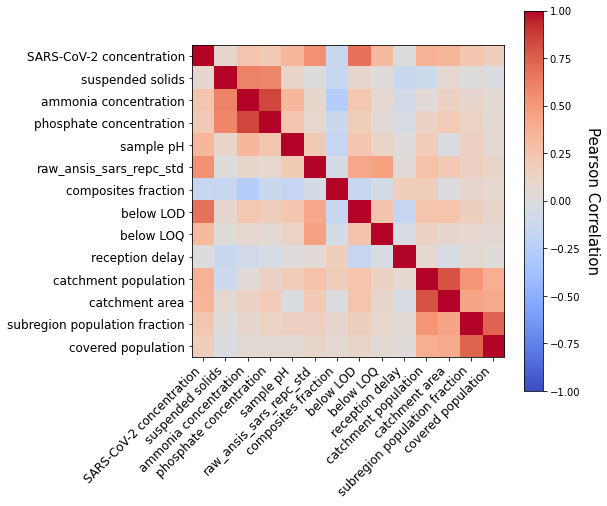

In [107]:
x, y = Dataset(df.set_index(['CIS20CD', 'date']), all_variables, 'median_prob', input_offset=0.001).prepare_no_split()
print(x.columns)
print(x.shape)

variables = all_variables
#variables.remove('reac_vol_control')
#print(variables)
#print(x[variables].corr())

plt.figure(figsize=(7,7))
plt.imshow(x[variables].corr(), cmap='coolwarm', vmin=-1.)
locs, labels=plt.xticks()
plt.xticks(range(len(x[variables].columns)), 
           [(variable_labels[l] if l in variable_labels else l) for l in x[variables].columns],
           rotation=45, horizontalalignment='right', fontsize=12)
plt.yticks(range(len(x[variables].columns)), 
           [(variable_labels[l] if l in variable_labels else l) for l in x[variables].columns],
           horizontalalignment='right', fontsize=12)
cbar = plt.colorbar()
cbar.ax.set_ylabel(f'Pearson Correlation', fontsize=15, rotation=270, labelpad=20)
pass
#plt.savefig(f'{ww.data_dir}/fS1_pearson.png',bbox_inches='tight') # save to main file loc


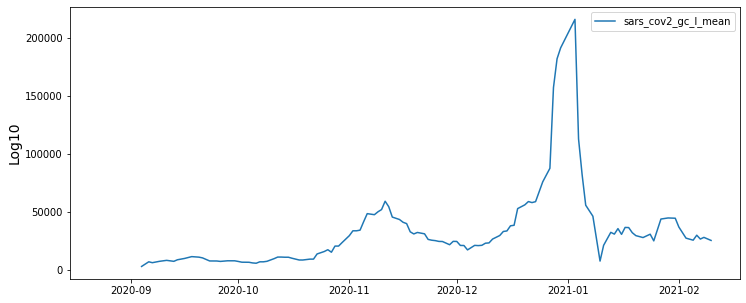

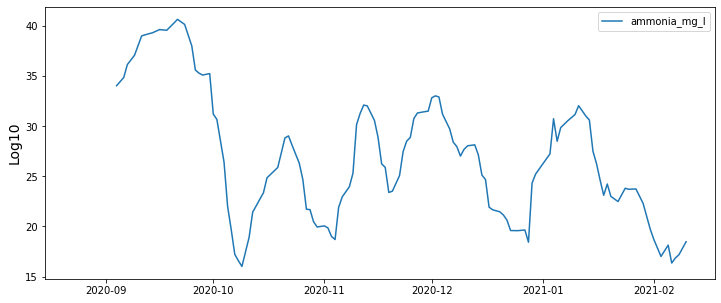

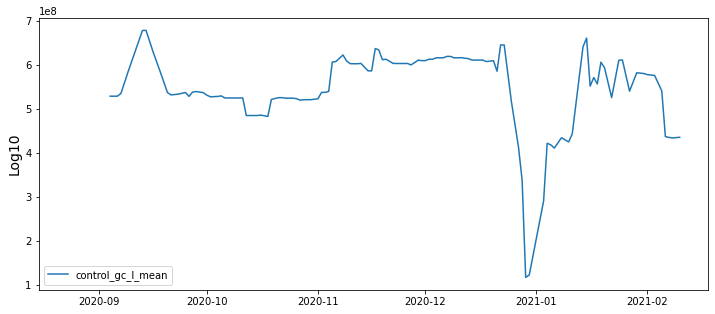

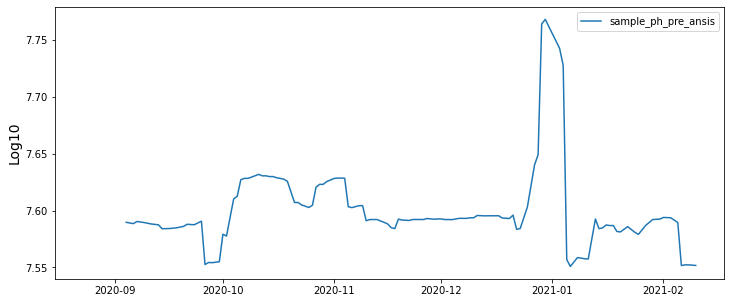

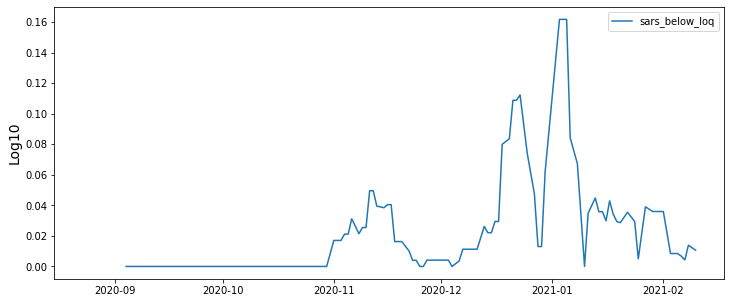

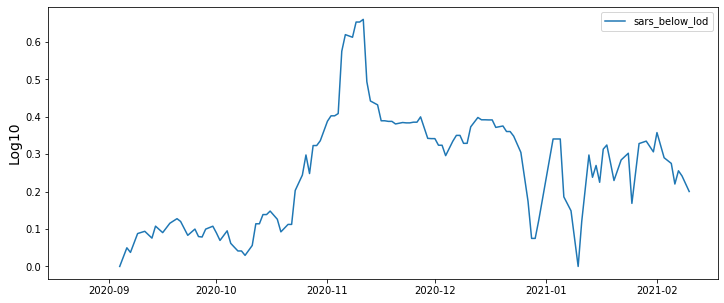

In [104]:
# Looking at some nationally averaged variables # , 'target_gene_N1'
for col in ['sars_cov2_gc_l_mean', 'ammonia_mg_l', 'control_gc_l_mean', 'sample_ph_pre_ansis', "sars_below_loq", 'sars_below_lod']:
    plt.figure(figsize=(12, 5))
    plt.plot(df.groupby('date').mean().rolling('7D').mean()[col], label=col)
    plt.xlim(datetime.datetime(2020, 8, 15))
#     plt.ylabel('SARS-CoV2 Concentration Log10(gc/L)', fontsize=13)
    plt.ylabel('Log10', fontsize=14)
    plt.legend()